# Polygons: NYT Boundary Map Recreation

This notebook references an old New York Times boundary map visualization. I attempted this project years ago and recently rediscovered the data tucked away in a forgotten corner of my hard drive. Time to dust it off and give it another shot.




In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
polygons = gpd.read_file("../data/combined.geojson")

/Users/qizhixuan/Documents/30DoM-2025/2025-11-03 - Polygons/.venv/lib/python3.11/site-packages/pyogrio/raw.py:198: RuntimeWarning: Several features with id = 29371 have been found. Altering it to be unique. This warning will not be emitted anymore for this layer
  return ogr_read(


In [3]:
neighborhood_cols = [col for col in polygons.columns if col.startswith("x")]
polygons[neighborhood_cols] = polygons[neighborhood_cols].fillna(0)
neighborhood_probs = polygons[neighborhood_cols].div(polygons[neighborhood_cols].sum(axis=1), axis=0).values

In [4]:
neighborhood_probs

array([[0.171     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.27972028, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.165     , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]], shape=(42726, 404))

In [5]:
neighborhood_log_probs = np.log(neighborhood_probs, where=neighborhood_probs > 0)
entropy = -1 * (neighborhood_probs * neighborhood_log_probs).sum(axis=1)

In [38]:
entropy_map = gpd.GeoDataFrame(
    {"entropy": entropy,
    "color": polygons["color"].values,
    "opacity": polygons["opacity"].values},
    geometry=polygons.geometry,
    crs=polygons.crs
)

<Axes: >

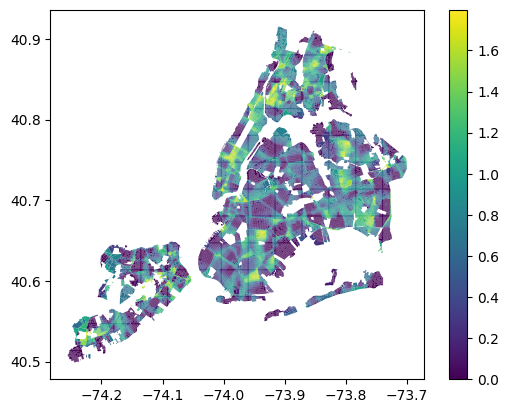

In [39]:
entropy_map.plot(column="entropy", cmap="viridis", legend=True)

In [40]:
entropy_map['entropy_normalized'] = (entropy_map['entropy'] - entropy_map['entropy'].min()) / (entropy_map['entropy'].max() - entropy_map['entropy'].min())
entropy_map['opacity_normalized'] = (entropy_map['opacity'] - entropy_map['opacity'].min()) / (entropy_map['opacity'].max() - entropy_map['opacity'].min())

In [48]:
entropy_map['entropy_normalized_weighted'] = entropy_map['entropy_normalized'] * entropy_map['opacity_normalized']
entropy_map['entropy_normalized_weighted_normalized'] = (entropy_map['entropy_normalized_weighted'] - entropy_map['entropy_normalized_weighted'].min()) / (entropy_map['entropy_normalized_weighted'].max() - entropy_map['entropy_normalized_weighted'].min())

In [45]:
import h3

In [49]:
RES = 10  # pick your resolution (0–15). Higher = smaller hexes.

# centroid -> H3 (lat, lon order!)
entropy_map["h3"] = entropy_map.geometry.centroid.apply(lambda p: h3.latlng_to_cell(p.y, p.x, RES))
entropy_map.head()

/var/folders/vd/gzdj2mfn1jz_dp6sdn79zs_h0000gn/T/ipykernel_6817/728347311.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  entropy_map["h3"] = entropy_map.geometry.centroid.apply(lambda p: h3.latlng_to_cell(p.y, p.x, RES))


,entropy,color,opacity,geometry,entropy_normalized,opacity_normalized,h3,entropy_normalized_weighted,entropy_normalized_weighted_normalized
0,1.182141,#729879,0.5,"POLYGON ((-74.2212 40.54785, -74.22164 40.5472...",0.657322,0.419765,8a2a1061d747fff,0.275921,0.294512
1,1.349162,#889277,0.5,"POLYGON ((-74.22449 40.54081, -74.22422 40.540...",0.750193,0.419765,8a2a10619917fff,0.314905,0.336122
2,1.460923,#839B73,0.5,"POLYGON ((-74.22422 40.54079, -74.22397 40.540...",0.812337,0.419765,8a2a1061991ffff,0.340991,0.363966
3,1.274927,#829F6F,0.5,"POLYGON ((-74.22397 40.54078, -74.22363 40.540...",0.708915,0.419765,8a2a1061991ffff,0.297578,0.317628
4,1.732868,#97A479,0.5,"POLYGON ((-74.22449 40.53613, -74.22409 40.532...",0.963550,0.419765,8a2a10619bb7fff,0.404465,0.431717


In [50]:
entropy_map.to_file("../entropy_map.geojson", driver="GeoJSON")

In [86]:
entropy_centroids = entropy_map.copy()
entropy_centroids.geometry = entropy_centroids.geometry.centroid
entropy_centroids['entropy_normalized'] = (entropy_centroids['entropy'] - entropy_centroids['entropy'].min()) /(entropy_centroids['entropy'].max() - entropy_centroids['entropy'].min())
entropy_centroids.to_file("../entropy_centroids_normalized.geojson", driver="GeoJSON")

/var/folders/vd/gzdj2mfn1jz_dp6sdn79zs_h0000gn/T/ipykernel_8359/2958843814.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  entropy_centroids.geometry = entropy_centroids.geometry.centroid


In [42]:
import json

def hex_to_rgb(h):
    h = h.lstrip('#')
    return [int(h[i:i+2], 16) for i in (0, 2, 4)]

with open("../entropy_map.geojson") as f:
    gj = json.load(f)

for feat in gj.get("features", []):
    hex_str = feat.get("properties", {}).get("color")
    if isinstance(hex_str, str) and hex_str.startswith("#") and len(hex_str)==7:
        feat.setdefault("properties", {})["fillColor"] = hex_to_rgb(hex_str)

In [ ]:
with open("../colored.geojson", "w") as f:
    json.dump(gj, f)

In [45]:
roads = gpd.read_file("../data/roads.geojson")

In [65]:
import osmnx as ox

In [66]:
# Get parkways in NYC
# NYC bounding box (approximate)
place_name = "New York City, New York, USA"

# Get road network with parkways
G = ox.graph_from_place(place_name, network_type='drive')

# Filter for parkways
parkways = ox.graph_to_gdfs(G, nodes=False)
# parkways = parkways[parkways['name'].str.contains('Parkway', case=False, na=False)]

<Axes: >

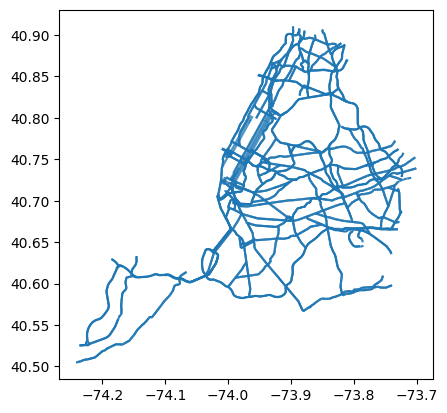

In [75]:
parkways[parkways['highway'].isin(['motorway', 'trunk', 'primary'])].plot()

In [78]:
parkways[parkways['highway'].isin(['motorway', 'trunk', 'primary'])].to_file("../parkways.geojson", driver="GeoJSON")

In [11]:
parkways = gpd.read_file("../parkways.geojson")

Skipping field lanes: unsupported OGR type: 5
Skipping field maxspeed: unsupported OGR type: 5
Skipping field name: unsupported OGR type: 5
Skipping field ref: unsupported OGR type: 5
Skipping field bridge: unsupported OGR type: 5
Skipping field tunnel: unsupported OGR type: 5


In [15]:
entropy_map['entropy_normalized'] = (entropy_map['entropy'] - entropy_map['entropy'].min()) / (entropy_map['entropy'].max() - entropy_map['entropy'].min())

# Clustering blocks into neighborhoods using HDBSCAN

We'll use HDBSCAN (Hierarchical Density-Based Spatial Clustering of Applications with Noise) to group blocks into neighborhoods based on their spatial proximity and entropy characteristics. This unsupervised clustering approach will help us identify natural neighborhood boundaries without requiring predefined cluster counts.


In [11]:
import numpy as np
from sklearn.cluster import DBSCAN

In [27]:
# Track different eps values and their resulting cluster counts
eps_results = []
best_model = None
best_eps = None
min_diff = float('inf')
target_clusters = 350

for eps in np.arange(0.05, 0.51, 0.05):
    clustering_temp = DBSCAN(eps=eps).fit(neighborhood_probs)
    n_clusters = len(np.unique(clustering_temp.labels_[clustering_temp.labels_ != -1]))
    eps_results.append({'eps': eps, 'n_clusters': n_clusters})
    
    # Track model closest to 350 clusters
    diff = abs(n_clusters - target_clusters)
    if diff < min_diff:
        min_diff = diff
        best_model = clustering_temp
        best_eps = eps
    
    print(f"eps={eps:.2f}: {n_clusters} clusters")

print(f"\nBest eps: {best_eps:.2f} with {len(np.unique(best_model.labels_[best_model.labels_ != -1]))} clusters (closest to {target_clusters})")

eps=0.05: 826 clusters
eps=0.10: 529 clusters
eps=0.15: 308 clusters
eps=0.20: 171 clusters
eps=0.25: 92 clusters
eps=0.30: 39 clusters
eps=0.35: 27 clusters
eps=0.40: 20 clusters
eps=0.45: 13 clusters
eps=0.50: 10 clusters

Best eps: 0.15 with 308 clusters (closest to 350)


<Axes: >

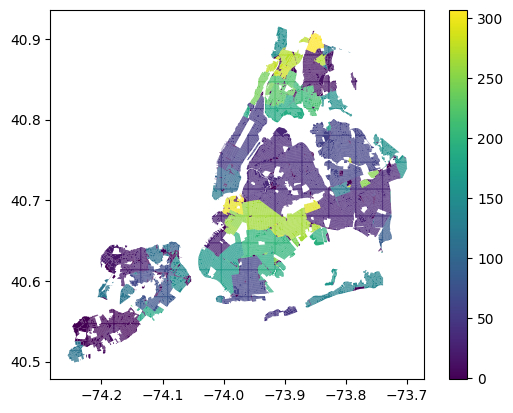

In [28]:
entropy_map['cluster'] = best_model.labels_
entropy_map.plot(column='cluster', cmap='viridis', legend=True)

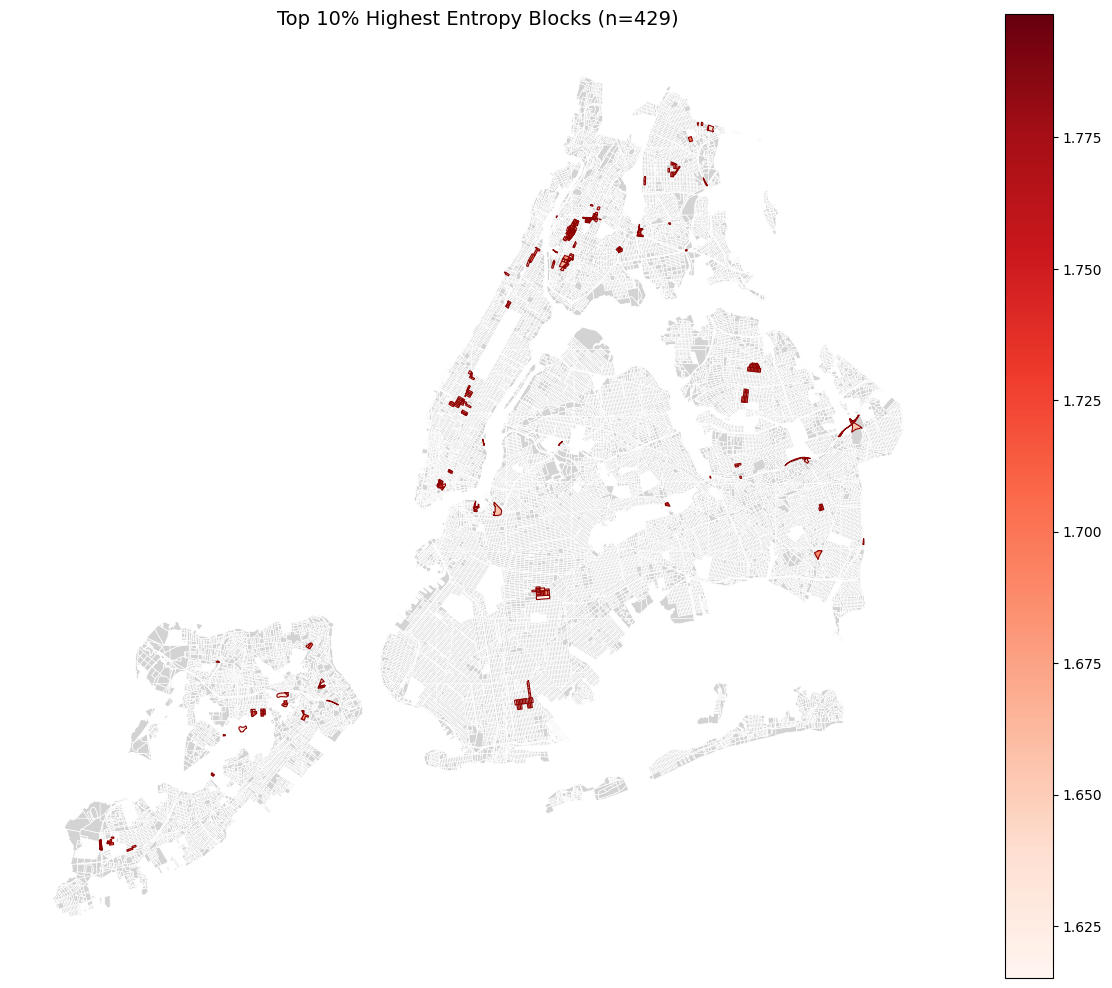

In [32]:
# Calculate the 90th percentile threshold for entropy
entropy_threshold = entropy_map['entropy'].quantile(0.99)

# Create a figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot all blocks in grey as background
entropy_map.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.5)

# Plot top 10% highest entropy blocks on top
high_entropy_blocks = entropy_map[entropy_map['entropy'] >= entropy_threshold]
high_entropy_blocks.plot(ax=ax, column='entropy', cmap='Reds', edgecolor='darkred', linewidth=0.8, legend=True)

ax.set_title(f'Top 10% Highest Entropy Blocks (n={len(high_entropy_blocks)})', fontsize=14)
ax.set_axis_off()
plt.tight_layout()